# 0. Datasets Variable Descriptions

## ⚡ Energy Dataset Variables

The energy dataset contains hourly electricity generation values by source, load information, and market price.

---

##### 🔋 Generation Variables (Energy Produced by Each Source)

**`generation_biomass`**  
Electricity produced from biomass combustion. Renewable but dispatchable, with moderate cost.

**`generation_fossil_brown_coal_lignite`**  
Electricity generated from lignite-fired plants. Cheap but polluting baseload source.

**`generation_fossil_coal-derived_gas`**  
Electricity produced from gases derived from coal processing. Less common and relatively high-cost.

**`generation_fossil_gas`**  
Generation from natural gas plants. Often the marginal price setter in European electricity markets.

**`generation_fossil_hard_coal`**  
Electricity from hard coal plants. Used mainly as baseload or mid-merit generation.

**`generation_fossil_oil`**  
Electricity produced from oil-based power plants. Very expensive; typically dispatched only during peak hours.

**`generation_fossil_oil_shale`**  
Electricity produced from oil shale combustion. Rare and high-cost.

**`generation_fossil_peat`**  
Electricity produced from peat combustion. Similar to coal but with lower energy density.

**`generation_geothermal`**  
Electricity generated from geothermal heat sources. Stable, renewable, and typically low marginal cost.

---

##### 💧 Hydro Generation Variables

**`generation_hydro_pumped_storage_aggregated`**
Electricity generated by pumped-storage hydro plants during discharge.

**`generation_hydro_pumped_storage_consumption`**  
Electricity consumed during pumping operations. Represents energy used to store water.

**`generation_hydro_run-of-river_and_poundage`**  
Electricity produced from run-of-river hydro plants, highly dependent on river flow.

**`generation_hydro_water_reservoir`**  
Generation from hydroelectric reservoirs. Used strategically during high-price periods.

---

##### ☢️ Other Generation Sources

**`generation_marine`**  
Electricity produced from marine energy sources (waves/tides). Rare and experimental.

**`generation_nuclear`**  
Stable baseload electricity from nuclear plants. Very low marginal cost.

**`generation_other`**  
Electricity generated from unspecified sources.

**`generation_other_renewable`**  
Renewable energy not classified into other specific categories.

**`generation_solar`**  
Electricity generated from solar photovoltaic systems. Highly dependent on sunlight and time of day.

**`generation_waste`**  
Electricity produced from waste incineration.

**`generation_wind_offshore`**  
Electricity generated by offshore wind farms. Typically more stable winds and higher output.

**`generation_wind_onshore`**  
Electricity produced from onshore wind turbines. More variable due to local wind patterns.

---

##### 🌬 Forecast Variable

**`forecast_wind_offshore_eday_ahead`**  
Day-ahead forecast of offshore wind generation. Forecast accuracy influences expected market prices.

---

##### 🔌 Load / Demand Variable

**`total_load_actual`**  
Measured hourly electricity demand. A primary driver of electricity prices — higher load usually increases price.

---

##### 💶 Price Variable (Target)

**`price_day_ahead`**  
The day-ahead hourly electricity price. This is the **target variable** for prediction in the project.


## 🌦 Weather Dataset Variables

The weather dataset provides hourly meteorological conditions that influence electricity demand and renewable generation.

---

##### 🌡 Temperature

**`temperature`**  
Air temperature. Strongly influences heating and cooling demand, and therefore total electricity consumption.

---

##### 🧭 Atmospheric Pressure

**`pressure`**  
Atmospheric pressure. Useful for identifying weather systems that affect wind availability.

---

##### 💧 Humidity

**`humidity`**  
Relative humidity of the air. Provides atmospheric context but has indirect influence on electricity systems.

---

##### 🌬 Wind

**`wind_speed`**  
Wind speed at the measurement location. Directly affects wind power production levels and therefore supply conditions in the electricity market.

# 1. Data understanding and preparation

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

energy = pd.read_csv("Dataset/energy_dataset.csv", parse_dates=["time"], index_col="time")
weather = pd.read_csv("Dataset/weather.csv", parse_dates=["time"], index_col="time")

energy.head(), weather.head()

(                           generation_biomass  \
 time                                            
 2015-01-01 00:00:00+01:00               447.0   
 2015-01-01 01:00:00+01:00               449.0   
 2015-01-01 02:00:00+01:00               448.0   
 2015-01-01 03:00:00+01:00               438.0   
 2015-01-01 04:00:00+01:00               428.0   
 
                            generation_fossil_brown_coal_lignite  \
 time                                                              
 2015-01-01 00:00:00+01:00                                 329.0   
 2015-01-01 01:00:00+01:00                                 328.0   
 2015-01-01 02:00:00+01:00                                 323.0   
 2015-01-01 03:00:00+01:00                                 254.0   
 2015-01-01 04:00:00+01:00                                 187.0   
 
                            generation_fossil_coal-derived_gas  \
 time                                                            
 2015-01-01 00:00:00+01:00            

### Checking the datasets shape

In [2]:
print("Energy shape:", energy.shape)
print("Weather shape:", weather.shape)

energy.info()
weather.info()

Energy shape: (35064, 24)
Weather shape: (35064, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           35045 non-null  float64
 1   generation_fossil_brown_coal_lignite         35046 non-null  float64
 2   generation_fossil_coal-derived_gas           35046 non-null  float64
 3   generation_fossil_gas                        35046 non-null  float64
 4   generation_fossil_hard_coal                  35046 non-null  float64
 5   generation_fossil_oil                        35045 non-null  float64
 6   generation_fossil_oil_shale                  35046 non-null  float64
 7   generation_fossil_peat                       35046 non-null  float64
 8   generation_geothermal                        35046 non-

In [3]:
#remover colunas sem valor relevante
cols_to_drop = ['generation_hydro_pumped_storage_aggregated', 'forecast_wind_offshore_eday_ahead']
energy = energy.drop(columns=cols_to_drop)

### Checking the datasets statistics

In [4]:
energy.describe()

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_coal-derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_consumption,generation_hydro_run-of-river_and_poundage,generation_hydro_water_reservoir,generation_marine,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,total_load_actual,price_day_ahead
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35028.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,28696.939905,49.874341
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,4574.987950,14.618900
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,18041.000000,2.060000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,24807.750000,41.490000
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,28901.000000,50.520000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,32192.000000,60.530000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,41015.000000,101.990000


In [5]:
weather.describe()

,temperature,pressure,humidity,wind_speed
count,35064.000000,35064.000000,35064.000000,35064.000000
mean,289.706862,1017.297872,68.033025,2.442944
std,7.251796,6.363845,14.814871,1.276415
min,272.006000,999.500000,22.600000,0.000000
25%,284.098877,1013.475000,56.750000,1.400000
50%,289.036200,1017.000000,69.600000,2.200000
75%,295.100500,1021.000000,80.000000,3.200000
max,309.048000,1035.500000,100.000000,8.500000


### Checking for null/missing values

In [6]:
summary = pd.DataFrame({
    'percent_null': energy.isna().mean() * 100,
    'percent_zero': (energy == 0).mean() * 100
})

summary

,percent_null,percent_zero
generation_biomass,0.054187,0.011408
generation_fossil_brown_coal_lignite,0.051335,29.993726
generation_fossil_coal-derived_gas,0.051335,99.948665
generation_fossil_gas,0.051335,0.002852
generation_fossil_hard_coal,0.051335,0.008556
generation_fossil_oil,0.054187,0.008556
generation_fossil_oil_shale,0.051335,99.948665
generation_fossil_peat,0.051335,99.948665
generation_geothermal,0.051335,99.948665
generation_hydro_pumped_storage_consumption,0.054187,35.954255


In [7]:
#remover colunas só com valores 0 ou null
cols_zero_or_null = [
    col for col in energy.columns
    if (energy[col].isna() | (energy[col] == 0)).all()
]

cols_zero_or_null

#remover essas colunas
energy = energy.drop(columns=cols_zero_or_null)

In [8]:
summary = pd.DataFrame({
    'percent_null': weather.isna().mean() * 100,
    'percent_zero': (weather == 0).mean() * 100
})

summary

,percent_null,percent_zero
temperature,0.0,0.000000
pressure,0.0,0.000000
humidity,0.0,0.000000
wind_speed,0.0,0.005704


### Checking for duplicated indexes

In [9]:
print("Duplicated timestamps in energy:", energy.index.duplicated().sum())
print("Duplicated timestamps in weather:", weather.index.duplicated().sum())

Duplicated timestamps in energy: 0
Duplicated timestamps in weather: 0


### Verify temporal alignment

In [10]:
print("Energy:", energy.index.min(), " -> ", energy.index.max())
print("Weather:", weather.index.min(), " -> ", weather.index.max())

Energy: 2015-01-01 00:00:00+01:00  ->  2018-12-31 23:00:00+01:00
Weather: 2015-01-01 00:00:00+01:00  ->  2018-12-31 23:00:00+01:00


In [11]:
# 1. Criar a sequência completa esperada (de hora a hora)
full_range = pd.date_range(start=energy.index.min(),
                           end=energy.index.max(),
                           freq='h')

# 2. Encontrar os timestamps que faltam
missing = full_range.difference(energy.index)

# 3. Ver quantos faltam e quais são
print(f"Total de horas em falta: {len(missing)}")
print("\nPrimeiros timestamps em falta:")
print(missing[:10]) 


# 1. Criar a sequência completa esperada (de hora a hora)
full_range = pd.date_range(start=weather.index.min(),
                           end=weather.index.max(),
                           freq='h')

# 2. Encontrar os timestamps que faltam
missing = full_range.difference(weather.index)

# 3. Ver quantos faltam e quais são
print(f"\nTotal de horas em falta: {len(missing)}")
print("\nPrimeiros timestamps em falta:")
print(missing[:10]) 



Total de horas em falta: 0

Primeiros timestamps em falta:
DatetimeIndex([], dtype='datetime64[ns, UTC+01:00]', freq='h')

Total de horas em falta: 0

Primeiros timestamps em falta:
DatetimeIndex([], dtype='datetime64[ns, UTC+01:00]', freq='h')


### Joining the datasets by time index

In [12]:
df = energy.join(weather, how="inner")
df.shape

(35064, 20)

In [13]:
df.describe()

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run-of-river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_onshore,total_load_actual,price_day_ahead,temperature,pressure,humidity,wind_speed
count,35045.000000,35046.000000,35046.000000,35046.000000,35045.000000,35045.000000,35045.000000,35046.000000,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.000000,35028.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.513540,448.059208,5622.737488,4256.065742,298.319789,475.577343,972.116108,2605.114735,6263.907039,60.228585,85.639702,1432.665925,269.452133,5464.479769,28696.939905,49.874341,289.706862,1017.297872,68.033025,2.442944
std,85.353943,354.568590,2201.830478,1961.601013,52.520673,792.406614,400.777536,1835.199745,839.667958,20.238381,14.077554,1680.119887,50.195536,3213.691587,4574.987950,14.618900,7.251796,6.363845,14.814871,1.276415
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18041.000000,2.060000,272.006000,999.500000,22.600000,0.000000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1077.250000,5760.000000,53.000000,73.000000,71.000000,240.000000,2933.000000,24807.750000,41.490000,284.098877,1013.475000,56.750000,1.400000
50%,367.000000,509.000000,4969.000000,4474.000000,300.000000,68.000000,906.000000,2164.000000,6566.000000,57.000000,88.000000,616.000000,279.000000,4849.000000,28901.000000,50.520000,289.036200,1017.000000,69.600000,2.200000
75%,433.000000,757.000000,6429.000000,5838.750000,330.000000,616.000000,1250.000000,3757.000000,7025.000000,80.000000,97.000000,2578.000000,310.000000,7398.000000,32192.000000,60.530000,295.100500,1021.000000,80.000000,3.200000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,119.000000,5792.000000,357.000000,17436.000000,41015.000000,101.990000,309.048000,1035.500000,100.000000,8.500000


### Setting target variable (price)

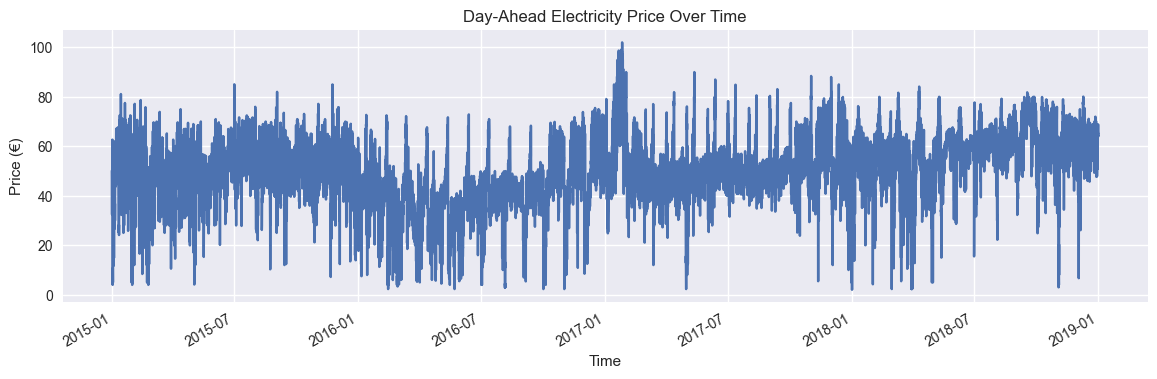

In [14]:
target = "price_day_ahead"

df[target].plot(figsize=(14,4))
plt.title("Day-Ahead Electricity Price Over Time")
plt.xlabel("Time")
plt.ylabel("Price (€)")
plt.show()

### Target variable correlations

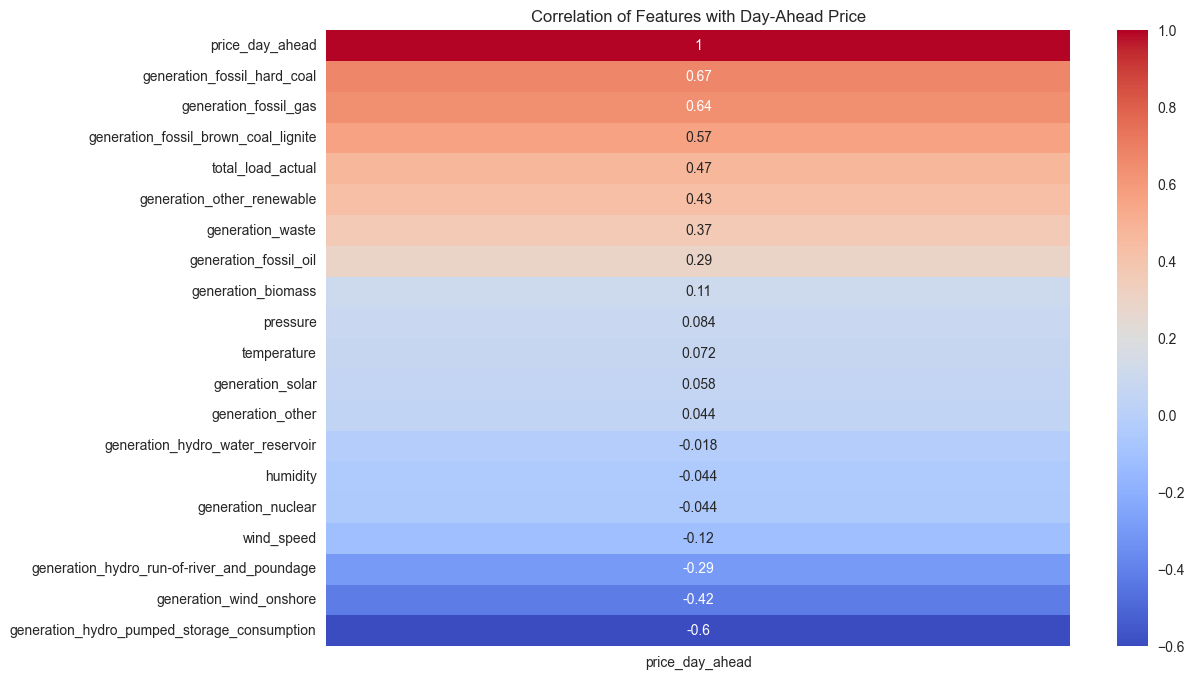

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True)[[target]].sort_values(by=target, ascending=False), 
            cmap="coolwarm", annot=True)
plt.title("Correlation of Features with Day-Ahead Price")
plt.show()

In [16]:
df.corr(numeric_only=True)[[target]].sort_values(by=target, ascending=False).head(20)

,price_day_ahead
price_day_ahead,1.000000
generation_fossil_hard_coal,0.671596
generation_fossil_gas,0.640895
generation_fossil_brown_coal_lignite,0.567905
total_load_actual,0.473869
generation_other_renewable,0.428078
generation_waste,0.368036
generation_fossil_oil,0.292793
generation_biomass,0.108945
pressure,0.084098


In [17]:
df.index = pd.to_datetime(df.index, utc=True).tz_convert(None)
df = df.sort_index()

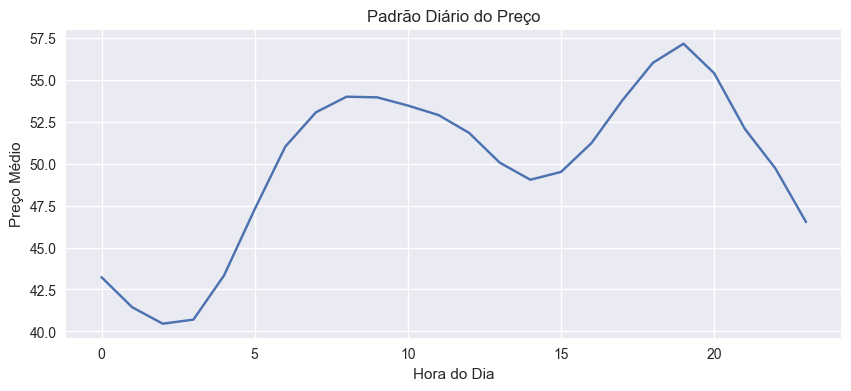

In [18]:
df['hour'] = df.index.hour
df.groupby('hour')['price_day_ahead'].mean().plot(figsize=(10,4))
plt.title("Padrão Diário do Preço")
plt.xlabel("Hora do Dia")
plt.ylabel("Preço Médio")
plt.show()

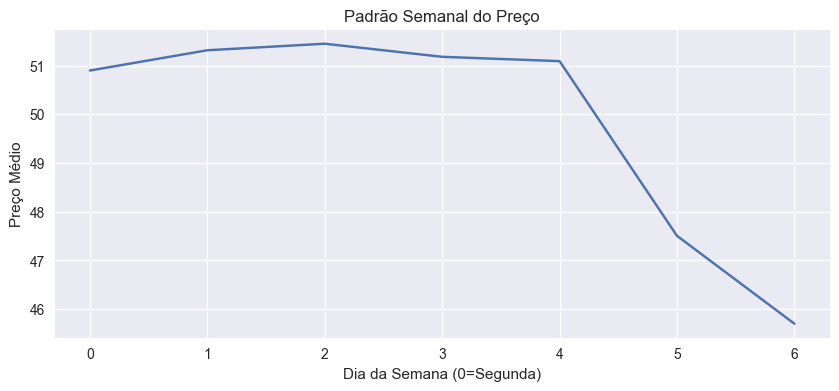

In [19]:
df['weekday'] = df.index.weekday
df.groupby('weekday')['price_day_ahead'].mean().plot(figsize=(10,4))
plt.title("Padrão Semanal do Preço")
plt.xlabel("Dia da Semana (0=Segunda)")
plt.ylabel("Preço Médio")
plt.show()


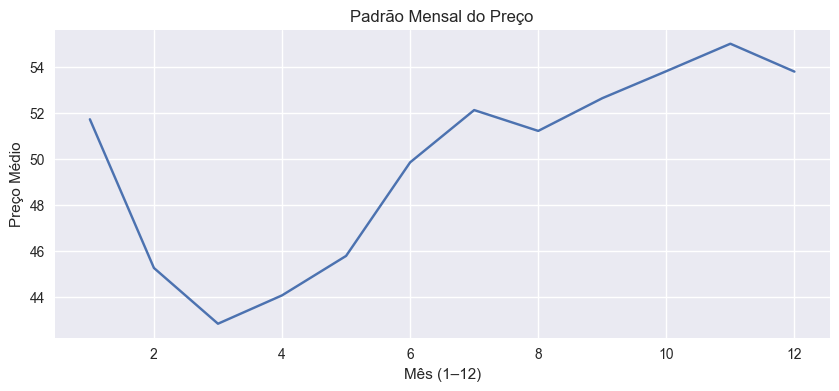

In [20]:
df['month'] = df.index.month

df.groupby('month')['price_day_ahead'].mean().plot(figsize=(10,4))
plt.title("Padrão Mensal do Preço")
plt.xlabel("Mês (1–12)")
plt.ylabel("Preço Médio")
plt.show()

In [21]:
df = df.drop(['hour', 'weekday', 'month'], axis=1)

# 2. Data pre-processing

In [22]:
# modelo para as statisticals
df_stat = df.copy()
df_stat = df_stat.ffill().bfill()

train_stat = df_stat.loc[:'2017-12-31'].asfreq('h')
test_stat  = df_stat.loc['2018-01-01':].asfreq('h')

print(train_stat.shape, test_stat.shape)
print(train_stat.index.min(), train_stat.index.max())

(26305, 20) (8759, 20)
2014-12-31 23:00:00 2017-12-31 23:00:00


In [49]:
df_ml = df.copy()

# interpolar apenas buracos simples
df_ml = df_ml.interpolate(method='linear')

# features temporais
df_ml['hour_of_day'] = df_ml.index.hour
df_ml['day_of_week'] = df_ml.index.weekday
df_ml['month'] = df_ml.index.month
df_ml['is_weekend'] = (df_ml.index.weekday >= 5).astype(int)

# target
target = 'price_day_ahead'

# lags e rolling features
df_ml['lag_1'] = df_ml[target].shift(1)
df_ml['lag_24'] = df_ml[target].shift(24)
df_ml['rolling_6h'] = df_ml[target].rolling(6).mean()
df_ml['mean_24'] = df_ml[target].rolling(24).mean()
df_ml['rolling_72h'] = df_ml[target].rolling(72).mean()
df_ml['std_24h'] = df_ml[target].rolling(24).std()
# remover linhas com NaN resultantes das features de lag/rolling
df_ml = df_ml.dropna()

# -------------------------
# NORMALIZAÇÃO (só features)
# -------------------------
from sklearn.preprocessing import MinMaxScaler

feature_cols = df_ml.columns.drop(target)

scaler = MinMaxScaler()
df_ml_scaled = df_ml.copy()
df_ml_scaled[feature_cols] = scaler.fit_transform(df_ml[feature_cols])

# -------------------------
# SPLIT TREINO / TESTE
# -------------------------
train_ml = df_ml_scaled.loc[:'2017-12-31']
test_ml  = df_ml_scaled.loc['2018-01-01':]

3. Modelling: creation of models to predict electricity price 1-step ahead and 24-step ahead (one day).


In [50]:
##parte 3
# exemplo: usar 2016-01-01 até 2017-12-31 para treino estatístico
target = 'price_day_ahead'

# correlação absoluta das variáveis com o target
correlations = train_stat.corr()[target].abs().sort_values(ascending=False)
print(correlations)

# threshold mínimo
threshold = 0.5

# colunas que ficam
keep_cols = correlations[correlations >= threshold].index.tolist()

# garantir que o target fica sempre
if target not in keep_cols:
    keep_cols.append(target)

# reduzir train e test
train_stat = train_stat[keep_cols]
test_stat  = test_stat[keep_cols]

# endógena
y_train = train_stat[target]
y_test  = test_stat[target]

# exógenas = todas as colunas exceto o target
exog_cols = [col for col in train_stat.columns if col != target]

exog_train = train_stat[exog_cols]
exog_test  = test_stat[exog_cols]

print("Target:", target)
print("Exógenas:", exog_cols)
print("Train shape:", train_stat.shape)
print("Test shape:", test_stat.shape)

price_day_ahead                                1.000000
generation_fossil_hard_coal                    0.775857
generation_fossil_brown_coal_lignite           0.670941
generation_fossil_gas                          0.659881
generation_hydro_pumped_storage_consumption    0.581411
total_load_actual                              0.504830
Name: price_day_ahead, dtype: float64
Target: price_day_ahead
Exógenas: ['generation_fossil_hard_coal', 'generation_fossil_brown_coal_lignite', 'generation_fossil_gas', 'generation_hydro_pumped_storage_consumption', 'total_load_actual']
Train shape: (26305, 6)
Test shape: (8759, 6)


ADF


In [51]:
result = adfuller(y_train)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -11.020701645670247
p-value: 5.99796379723378e-20


ACF/PACF

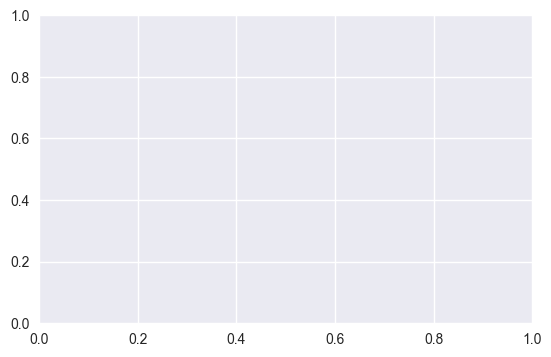

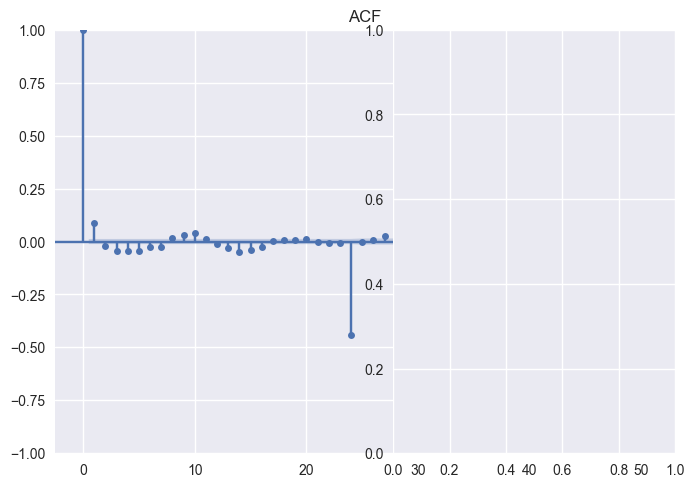

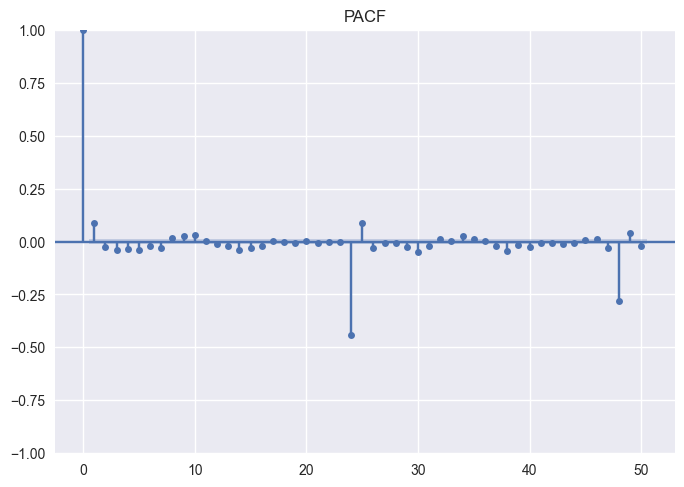

In [52]:
# differencing para visualizar melhor
y_diff = y_train.diff().dropna()
y_seasonal = y_diff.diff(24).dropna()

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plot_acf(y_seasonal, lags=50)
plt.title("ACF")

plt.subplot(1,2,2)
plot_pacf(y_seasonal, lags=50)
plt.title("PACF")

plt.show()

SARIMA (AIC)

In [53]:
# 1) subset pequeno para busca de parâmetros
# y_search = y_train.iloc[:24*90]  # 3 meses, por exemplo

# # 2) grid reduzido
# p = q = [0, 1]
# d = 0   # ADF mostrou estacionaridade
# D = 1
# seasonal_period = 24

# pdq = list(itertools.product(p, [d], q))
# seasonal_pdq = [(x[0], D, x[2], seasonal_period)
#                 for x in itertools.product([0,1], [1], [0,1])]

# best_aic = np.inf
# best_order = None
# best_seasonal = None

# for order in pdq:
#     for s_order in seasonal_pdq:
#         try:
#             model = SARIMAX(
#                 y_search,
#                 order=order,
#                 seasonal_order=s_order,
#                 enforce_stationarity=False,
#                 enforce_invertibility=False
#             )
#             results = model.fit(disp=False)
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_order = order
#                 best_seasonal = s_order
#         except Exception:
#             continue

# print("Best SARIMA parameters:", best_order, best_seasonal, "AIC:", best_aic)

#Best SARIMA parameters: (1, 0, 1) (1, 1, 1, 24) AIC: 11629.21478561428

# 3) refitar o melhor modelo no treino completo (1 ano)

best_order = (1, 0, 1)
best_seasonal = (1, 1, 1, 24)
model_sarima = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarima = model_sarima.fit()
print(results_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    price_day_ahead   No. Observations:                26305
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -66251.206
Date:                            Sat, 13 Dec 2025   AIC                         132512.413
Time:                                    11:42:12   BIC                         132553.291
Sample:                                12-31-2014   HQIC                        132525.613
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9448      0.002    475.482      0.000       0.941       0.949
ma.L1          0.1726      0.005   

In [54]:
model_sarimax = SARIMAX(
    y_train,
    exog=exog_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarimax = model_sarimax.fit()
print(results_sarimax.summary())


C:\Users\Aoazevedo\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                    price_day_ahead   No. Observations:                26305
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -62079.509
Date:                            Sat, 13 Dec 2025   AIC                         124179.018
Time:                                    11:49:42   BIC                         124260.774
Sample:                                12-31-2014   HQIC                        124205.418
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
generation_fossil_hard_coal                     

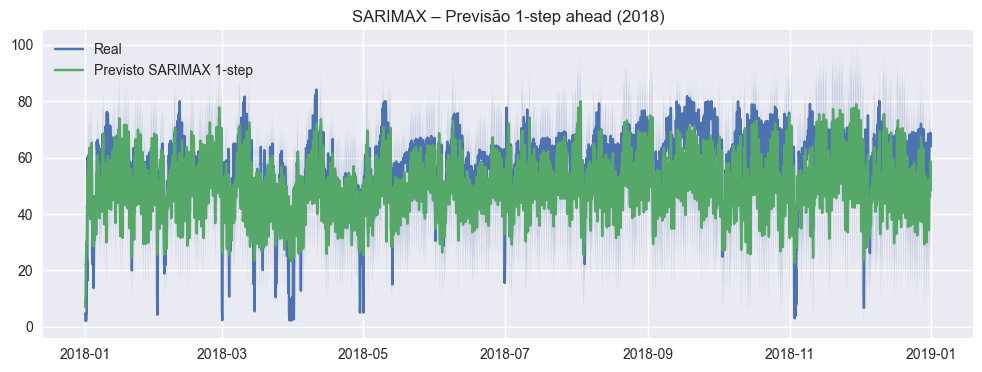

In [55]:
n_test = len(y_test)

forecast_sarimax = results_sarimax.get_forecast(
    steps=n_test,
    exog=exog_test
)

pred_sarimax = forecast_sarimax.predicted_mean
ci = forecast_sarimax.conf_int()

plt.figure(figsize=(12,4))
plt.plot(y_test, label='Real')
plt.plot(pred_sarimax, label='Previsto SARIMAX 1-step')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2)
plt.legend()
plt.title("SARIMAX – Previsão 1-step ahead (2018)")
plt.show()


In [56]:
pred_sarima = results_sarima.get_forecast(steps=n_test).predicted_mean


In [57]:
forecast_24 = results_sarimax.get_forecast(
    steps=24,
    exog=exog_test.iloc[:24]
)

pred_24 = forecast_24.predicted_mean
pred_24


2018-01-01 00:00:00     6.967245
2018-01-01 01:00:00     9.895644
2018-01-01 02:00:00     9.969774
2018-01-01 03:00:00    10.545375
2018-01-01 04:00:00    12.656002
2018-01-01 05:00:00    15.385610
2018-01-01 06:00:00    22.161782
2018-01-01 07:00:00    21.990226
2018-01-01 08:00:00    24.203180
2018-01-01 09:00:00    25.565108
2018-01-01 10:00:00    28.289076
2018-01-01 11:00:00    28.601371
2018-01-01 12:00:00    30.171304
2018-01-01 13:00:00    29.511565
2018-01-01 14:00:00    29.077196
2018-01-01 15:00:00    29.708988
2018-01-01 16:00:00    33.778650
2018-01-01 17:00:00    40.856080
2018-01-01 18:00:00    42.808659
2018-01-01 19:00:00    42.245546
2018-01-01 20:00:00    43.427514
2018-01-01 21:00:00    42.322935
2018-01-01 22:00:00    40.106685
2018-01-01 23:00:00    53.690337
Freq: h, Name: predicted_mean, dtype: float64

In [58]:
def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # remover NaN
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # evitar divisão por zero no MAPE
    non_zero = y_true != 0
    y_true = y_true[non_zero]
    y_pred = y_pred[non_zero]

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mae, rmse, mape


In [59]:
mae_sarima,  rmse_sarima,  mape_sarima  = compute_metrics(y_test, pred_sarima)
mae_sarimax, rmse_sarimax, mape_sarimax = compute_metrics(y_test, pred_sarimax)


In [60]:
results_stat = pd.DataFrame({
    "Model": ["SARIMA", "SARIMAX"],
    "MAE":   [mae_sarima, mae_sarimax],
    "RMSE":  [rmse_sarima, rmse_sarimax],
    "MAPE":  [mape_sarima, mape_sarimax]
})

results_stat


,Model,MAE,RMSE,MAPE
0,SARIMA,11.585485,14.161533,31.445282
1,SARIMAX,8.843793,10.829579,22.368966


Criar Sliding Window para Deep Learning

In [61]:
def create_windows(data, target_col, window_size=24):
    X, y = [], []
    values = data.values
    target_idx = data.columns.get_loc(target_col)
    
    for i in range(window_size, len(values)):
        X.append(values[i-window_size:i])          # janela de features
        y.append(values[i, target_idx])            # target seguinte

    return np.array(X), np.array(y)


In [62]:
window_size = 24  # previsão 1-step ahead baseado em 24h

X_train, y_train = create_windows(train_ml, target, window_size)
X_test,  y_test  = create_windows(test_ml,  target, window_size)

X_train.shape, X_test.shape


((26210, 24, 30), (8735, 24, 30))

Modelo LSTM

In [63]:

model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()


C:\Users\Aoazevedo\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        24,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,769 (143.63 KB)

 Trainable params: 36,769 (143.63 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 1080.8142 - val_loss: 826.7541
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 307.4440 - val_loss: 285.2197
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 104.9307 - val_loss: 119.9336
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 48.6153 - val_loss: 60.9268
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 28.5035 - val_loss: 35.0338
Epoch 6/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 19.9302 - val_loss: 22.6715
Epoch 7/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 15.9118 - val_loss: 15.0137
Epoch 8/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 13.4255 - val_loss: 12.2216
Epoch 9/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 12.0989 - val_loss: 9.6441
Epoch 10/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 11.0412 - val_loss: 8.7761
Epoch 11/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 10.2034 - val_loss: 8.3599
Epoch 12/50
73

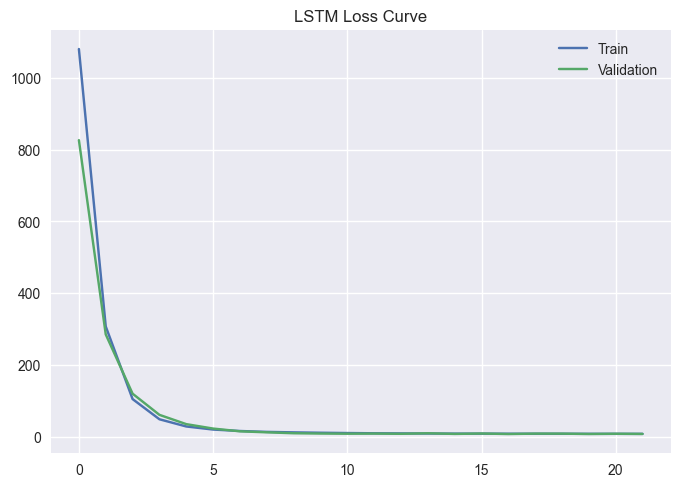

In [65]:

plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Validation')
plt.title("LSTM Loss Curve")
plt.legend()
plt.show()

In [66]:
pred_lstm = model_lstm.predict(X_test).flatten()

273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


Modelo GRU

In [67]:
model_gru = Sequential([
    tf.keras.layers.GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.GRU(32),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mse')
model_gru.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 24, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,873 (108.88 KB)

 Trainable params: 27,873 (108.88 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
history_gru = model_gru.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 1056.0221 - val_loss: 826.5452
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 307.8813 - val_loss: 286.2196
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 104.8200 - val_loss: 119.6782
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 48.0553 - val_loss: 60.6475
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 27.8851 - val_loss: 34.1835


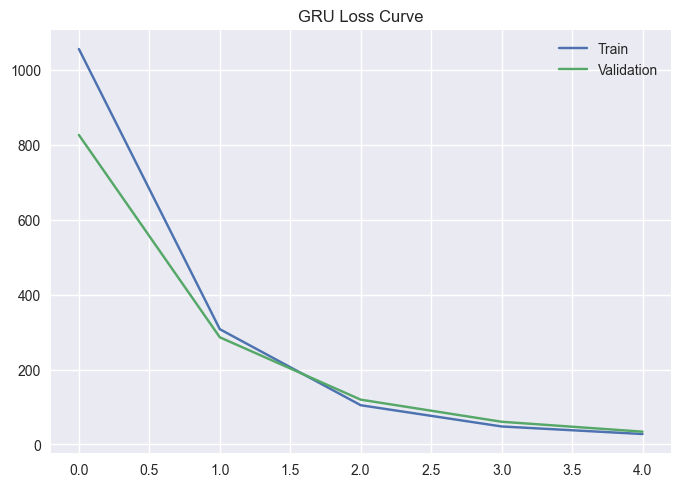

In [69]:
plt.plot(history_gru.history['loss'], label='Train')
plt.plot(history_gru.history['val_loss'], label='Validation')
plt.title("GRU Loss Curve")
plt.legend()
plt.show()


In [70]:
pred_gru = model_gru.predict(X_test).flatten()


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


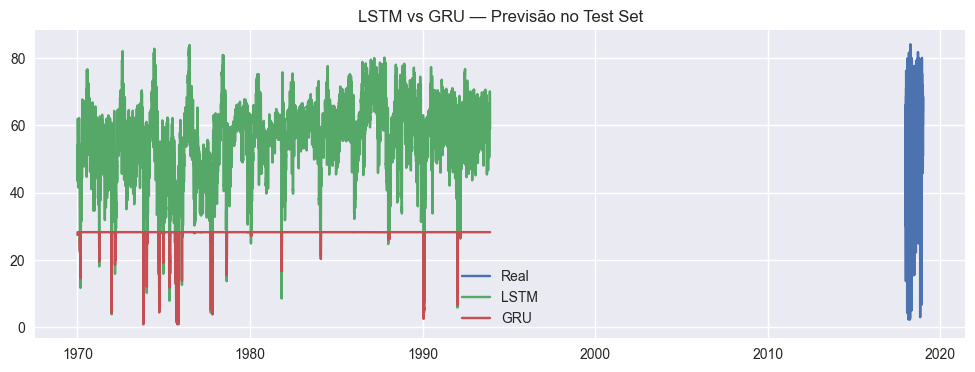

In [71]:

y_test_series = test_ml[target].iloc[window_size:]

plt.figure(figsize=(12,4))
plt.plot(y_test_series, label='Real')
plt.plot(pred_lstm, label='LSTM')
plt.plot(pred_gru, label='GRU')
plt.legend()
plt.title("LSTM vs GRU — Previsão no Test Set")
plt.show()


In [72]:
print(len(y_test))
print(len(pred_lstm))
print("min y_test:", np.min(y_test))
print("max y_test:", np.max(y_test))
print("NaN em pred_lstm:", np.isnan(pred_lstm).sum())
print("Inf em pred_lstm:", np.isinf(pred_lstm).sum())

print("NaN em pred_gru:", np.isnan(pred_gru).sum())
print("Inf em pred_gru:", np.isinf(pred_gru).sum())
mae_lstm, rmse_lstm, mape_lstm = compute_metrics(y_test, pred_lstm)
mae_gru,  rmse_gru,  mape_gru  = compute_metrics(y_test, pred_gru)


8735
8735
min y_test: 2.3
max y_test: 84.13
NaN em pred_lstm: 0
Inf em pred_lstm: 0
NaN em pred_gru: 0
Inf em pred_gru: 0


In [73]:
results_dl = pd.DataFrame({
    "Model": ["LSTM", "GRU"],
    "MAE":   [mae_lstm, mae_gru],
    "RMSE":  [rmse_lstm, rmse_gru],
    "MAPE":  [mape_lstm, mape_gru]
})

results_dl

,Model,MAE,RMSE,MAPE
0,LSTM,2.095226,3.072511,4.327238
1,GRU,29.610863,31.644221,49.434062
